## Определение стоимости автомобилей 
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

#### Заказчику важны:

качество предсказания;  
скорость предсказания;  
время обучения.  
### Описание данных
#### Признаки

DateCrawled — дата скачивания анкеты из базы   
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
#### Целевой признак

Price — цена (евро)

In [160]:
import pandas as pd
import numpy as np
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import phik

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


In [161]:
auto_data = pd.read_csv(r'E:/проекты/Проекты по DS/data/autos.csv')
#auto_data = auto_data.iloc[:1000]
print(auto_data.shape)

(354369, 16)


In [162]:
print(auto_data.head())

           DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired          DateCreated  NumberOfPictures  PostalCode             LastSeen
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   golf     150000                  0    petrol  volkswagen      NaN  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190    NaN     125000                  5  gasoline        audi      yes  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50
2  2016-03-14 12:52:21   9800         suv              2004    auto    163  grand     125000                  8  gasoline        jeep      NaN  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46
3  2016-03-17 16:54:04   1500       small              2001  manual     75   golf     150000                  6    petrol  volkswagen       

In [163]:
print(auto_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Столбцы названы не корректно

In [164]:
auto_data = auto_data.rename(columns={
    'DateCrawled': 'date_crawled',
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox_type',      
    'Power': 'engine_power',         
    'Kilometer': 'mileage',          
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Repaired': 'repair_status',   
    'DateCreated': 'date_created',
    'NumberOfPictures': 'number_of_pictures',
    'PostalCode': 'postal_code',
    'LastSeen': 'last_seen',
    'Model': 'model',
    'Brand': 'brand'
})

In [165]:
print(auto_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox_type        334536 non-null  object
 5   engine_power        354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repair_status       283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

В некоторых столбцах есть пропуски, также используется не верный тип данных для столбцолв с временными переменными

In [166]:
time_col = ['date_crawled', 'date_created', 'last_seen']
for col in time_col:
    auto_data[col] = pd.to_datetime(auto_data[col])

#### Преобразование временныз переменных  
  
Посмотри на уникальные значения, которые содержатся в столбцах

In [167]:
for col in time_col:
    print(col)
    print('Года:', auto_data[col].dt.year.unique())
    print('Месяца:', auto_data[col].dt.month.unique(), end='\n\n')

date_crawled
Года: [2016]
Месяца: [3 4]

date_created
Года: [2016 2015 2014]
Месяца: [ 3  4  2  1 11 12  9  8  6]

last_seen
Года: [2016]
Месяца: [4 3]



Таким образом, временные столбцы имеют слишком маленький период, так что можно их преобразовать в числовые признаки

При этом, количество объявлений, сделанных в 2015 году(столбец date_created) слишком мало, чтобы выделять под год создания целый столбец

In [168]:
auto_data[auto_data['date_created'].dt.year == 2015].shape[0]  

25

In [169]:
auto_data['crawled_month'] = auto_data['date_crawled'].dt.month
auto_data['last_seen_month'] = auto_data['last_seen'].dt.month
auto_data['created_month'] = auto_data['date_created'].dt.month

auto_data.drop(columns=['date_crawled', 'date_created', 'last_seen'], axis=1, inplace=True)

#### Поиск аномалий  

Проверим данные на наличие аномальных значений

In [170]:
def num_ditribution(data, xcols, titles, xlables, figsize, minus):
    fig, axs = plt.subplots(len(xcols), 2, figsize=figsize)
    for i in range(len(xcols)):
        sns.histplot(data=data, x=xcols[i], bins=20, ax=axs[i, 0])
        axs[i, 0].set_xlabel(xlables[i])
        axs[i, 0].set_ylabel('Количество')
        axs[i, 0].set_title(titles[i])

        sns.boxplot(x=data[xcols[i]], orient='h', ax=axs[i, 1])
        axs[i, 1].set_xlabel(xlables[i])
        axs[i, 1].set_title(titles[i])

    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.show()

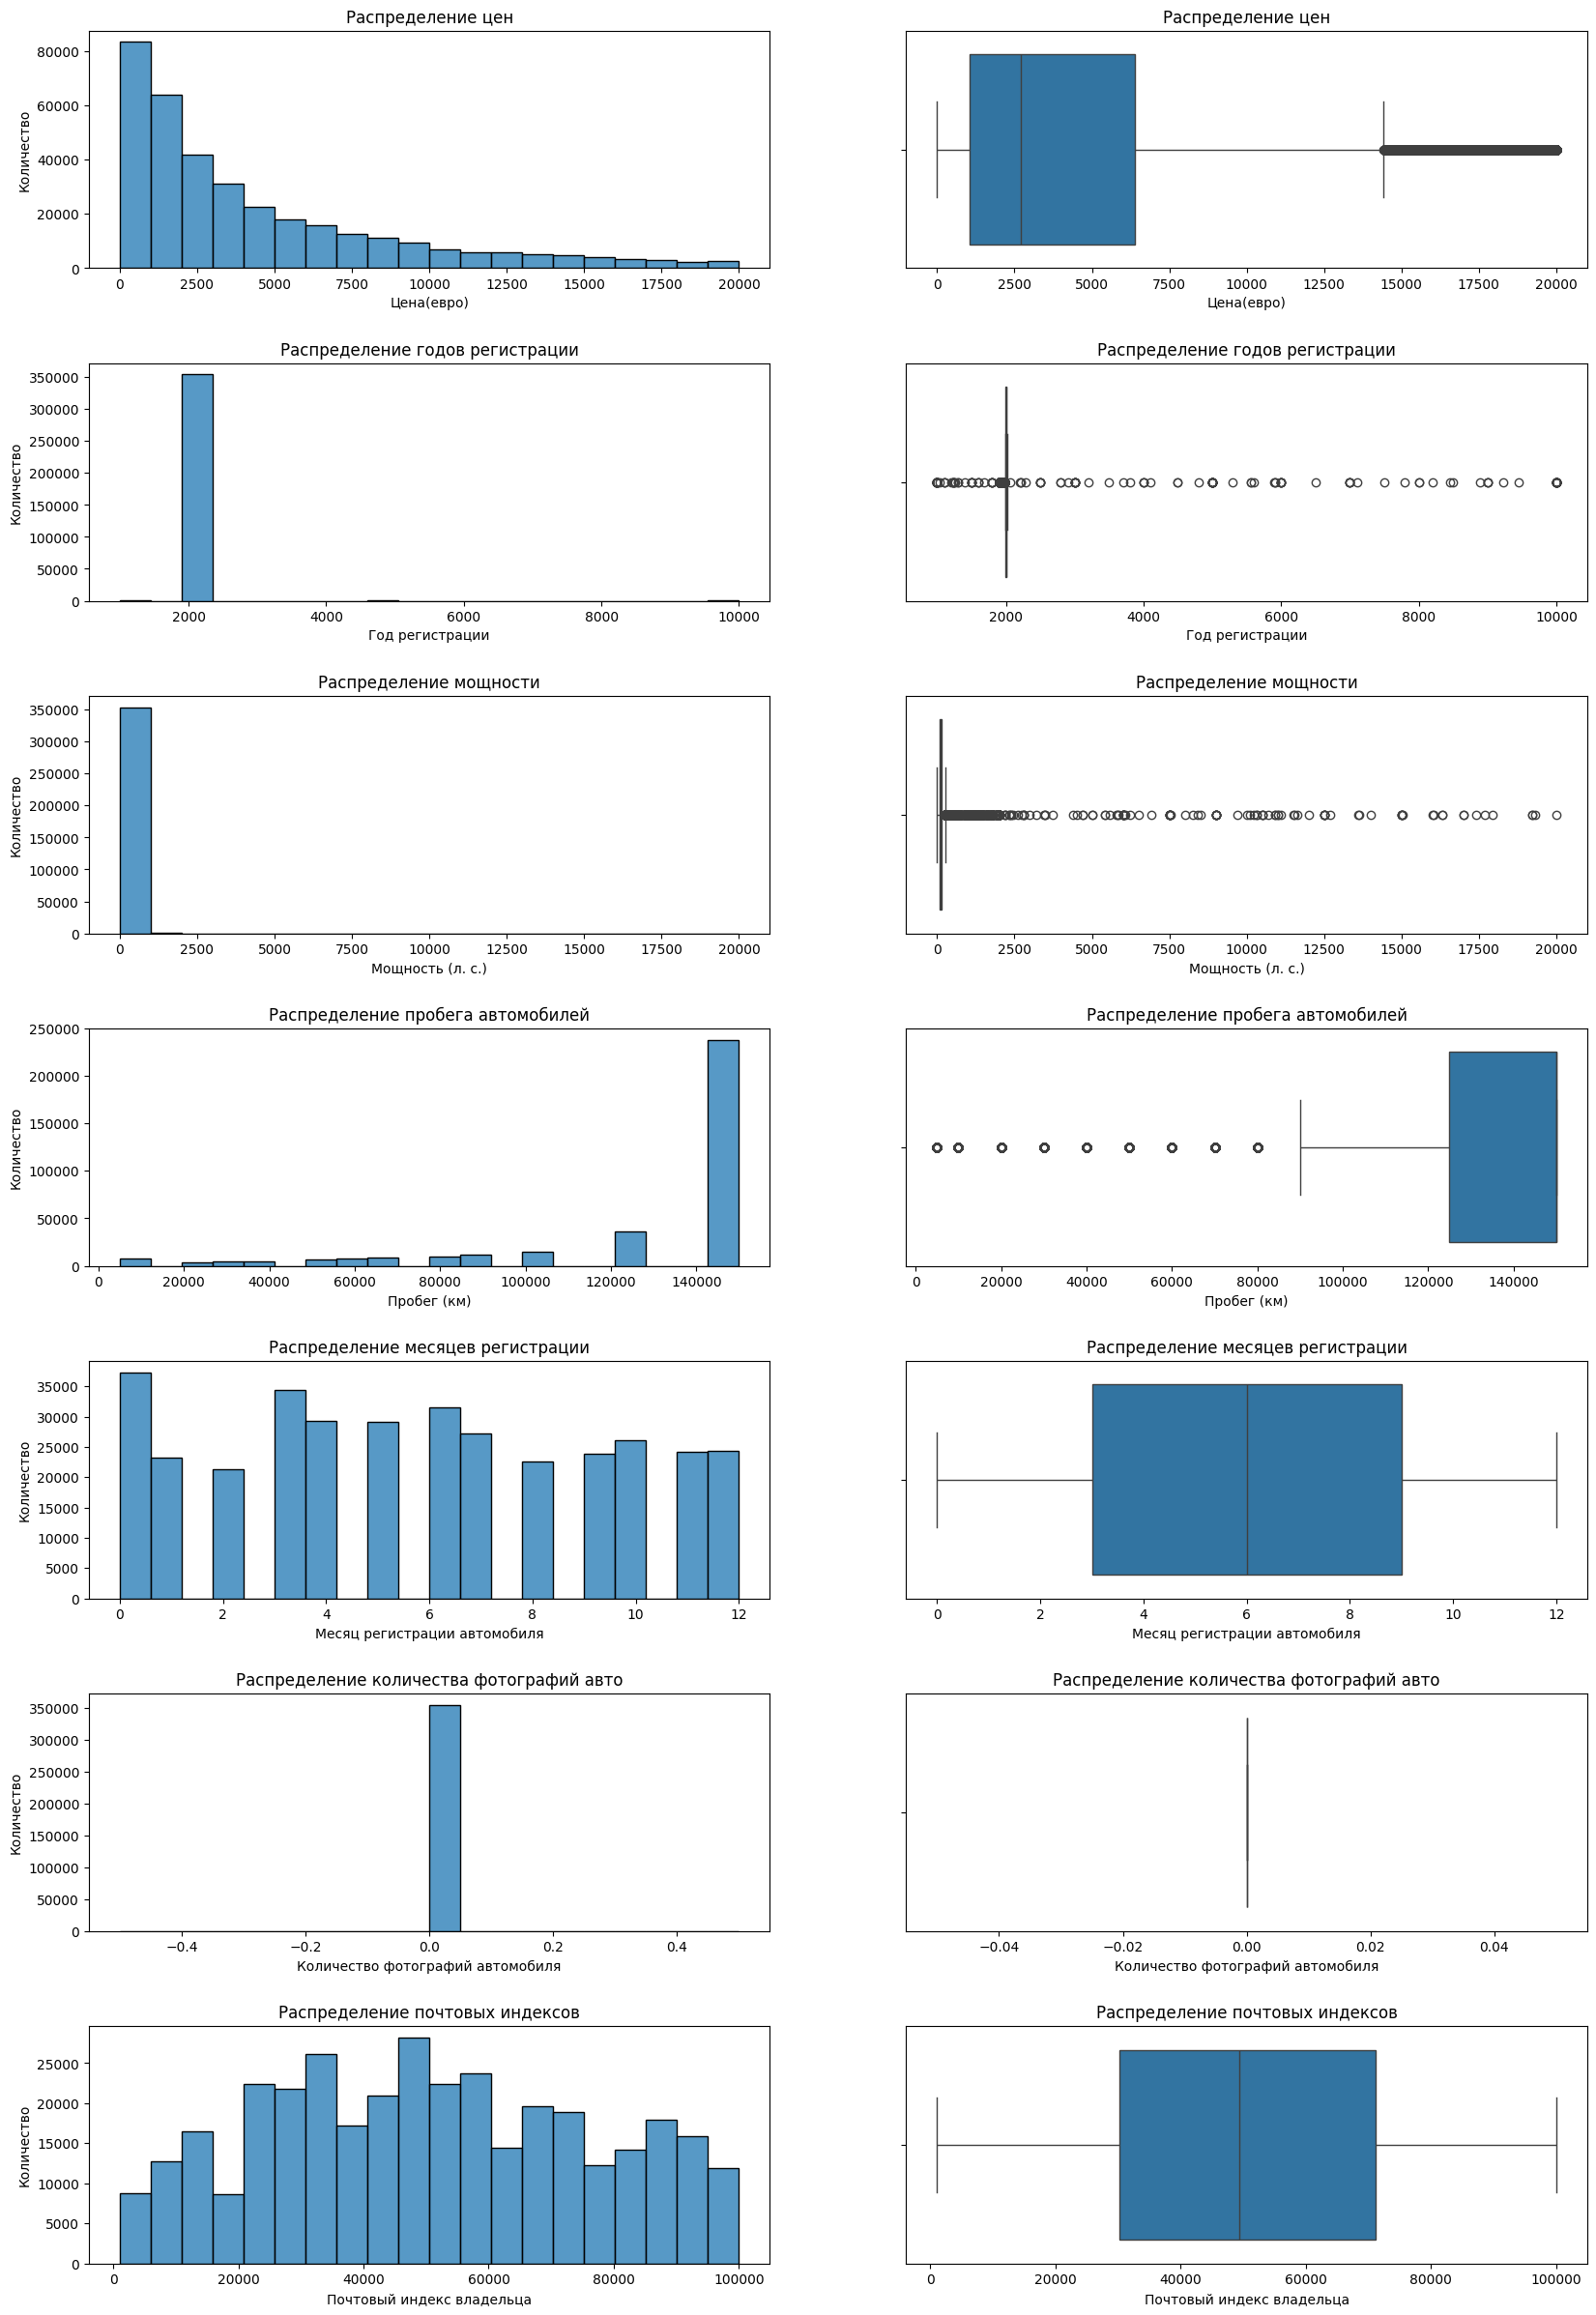

In [171]:
num_col = ['price', 'registration_year', 
       'engine_power', 'mileage', 'registration_month',
       'number_of_pictures', 'postal_code']

auto_data_num_xlabel = [
    'Цена(евро)',
    'Год регистрации',
    'Мощность (л. с.)',
    'Пробег (км)',
    'Месяц регистрации автомобиля',
    'Количество фотографий автомобиля',
    'Почтовый индекс владельца'
]
auto_data_num_title = [
    'Распределение цен',
    'Распределение годов регистрации',
    'Распределение мощности',
    'Распределение пробега автомобилей',
    'Распределение месяцев регистрации',
    'Распределение количества фотографий авто',
    'Распределение почтовых индексов'
]

num_ditribution(auto_data, num_col, auto_data_num_title, auto_data_num_xlabel, (20, 30), 1)

##### Что мы можем сказать по этим графикам  

Можно заметить, что в целевой переменной price присутствуют аномальные значения меньшие чем 200$, так как это целевая переменная, то заменить данные не получится так как это сильно вляет на качество модели, удалим эти значения    

Столбец engine_power также содержит аномальные значения(вряд ли на б.у. рынке есть машины с мощностью двигателя больше 1000 и меньше 40). В этом случае завышенные значения могут быть ошибками пользователя, так что их можно исправить на меньшие.  

В столбце registration_year присутствует большое количество некорректных значений(год регистрации превышает время выгрузки) или автомобилей, которые могут внести "шум" в модель (с годом регистрации меньше 1980). Следует узнать у заказчика дату последней выгрузки данных, а также возможность размещения коллекционных автомобилей на сервисе. Такие значения следует удалить, так как нет возможности изменить указанный год на верный.  

В столбце number_of_pictures присутвуют только нулевые значения - этот столбец не информативен и его нужно удалить  

In [172]:
auto_data = auto_data[auto_data["price"] > 200]
auto_data = auto_data[(auto_data["registration_year"] > 1980) & (auto_data["registration_year"] < 2016)] 




In [173]:
def devide_power_by_10(i):
     return i/ 10 if i > 1000 else i


auto_data = auto_data[(auto_data["engine_power"] > 30) & (auto_data["engine_power"] < 10000)]
auto_data["engine_power"] = auto_data["engine_power"].apply(devide_power_by_10)

In [174]:
auto_data = auto_data.drop("number_of_pictures", axis=1)
auto_data.reset_index(drop=True, inplace=True)

#### Обработка пропущенных значений  

посмотрим какой процент пропушенных значений содержится в каждом признаке

In [175]:
print((auto_data.isna().sum() / len(auto_data) * 100))

price                  0.000000
vehicle_type           1.472331
registration_year      0.000000
gearbox_type           1.573884
engine_power           0.000000
model                  3.294965
mileage                0.000000
registration_month     0.000000
fuel_type              4.236535
brand                  0.000000
repair_status         13.455503
postal_code            0.000000
crawled_month          0.000000
last_seen_month        0.000000
created_month          0.000000
dtype: float64


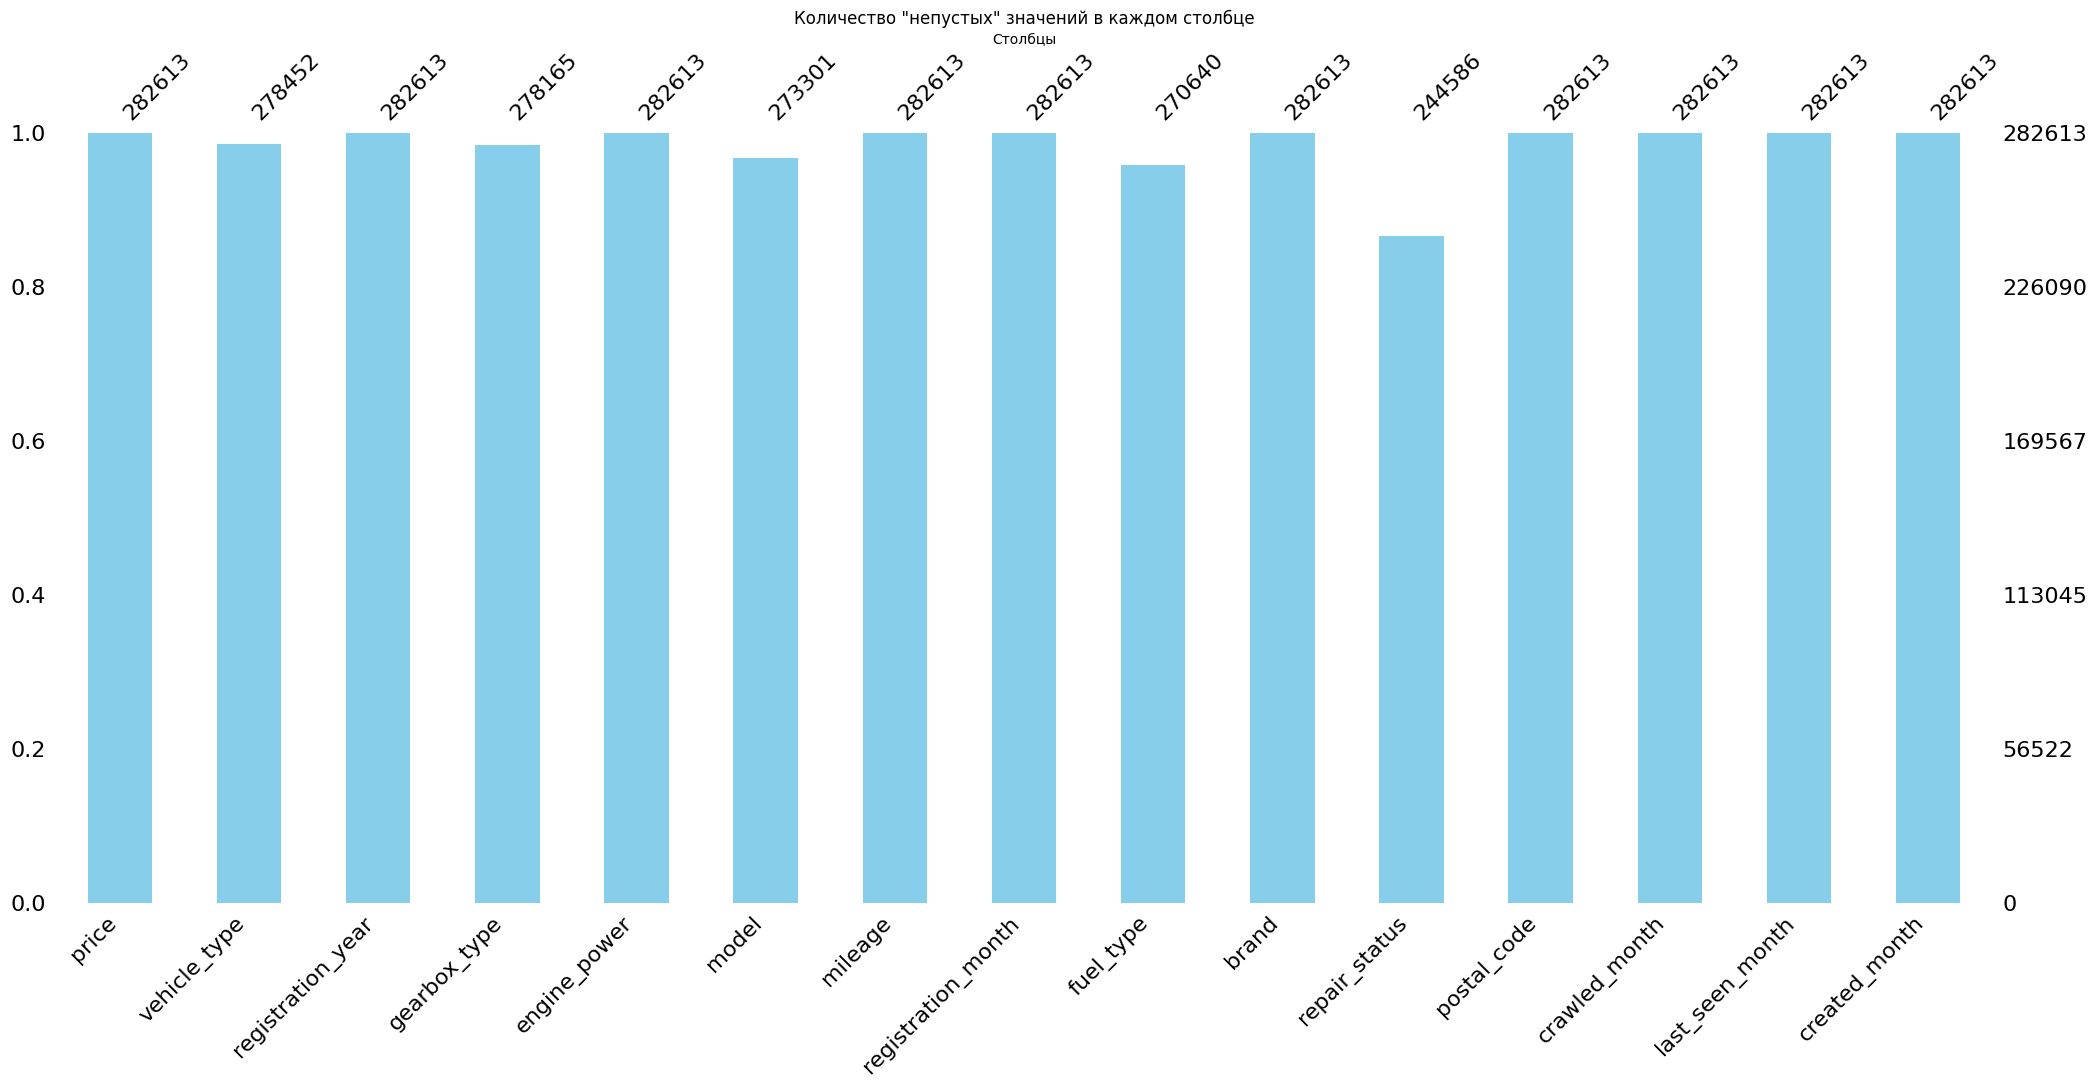

In [176]:
msno.bar(auto_data, color="skyblue")
plt.title('Количество "непустых" значений в каждом столбце')
plt.xlabel('Столбцы')
plt.show();

Посмотрим, связаны ли пропуски в одном столбце с пропусками в других параметрах

<Axes: >

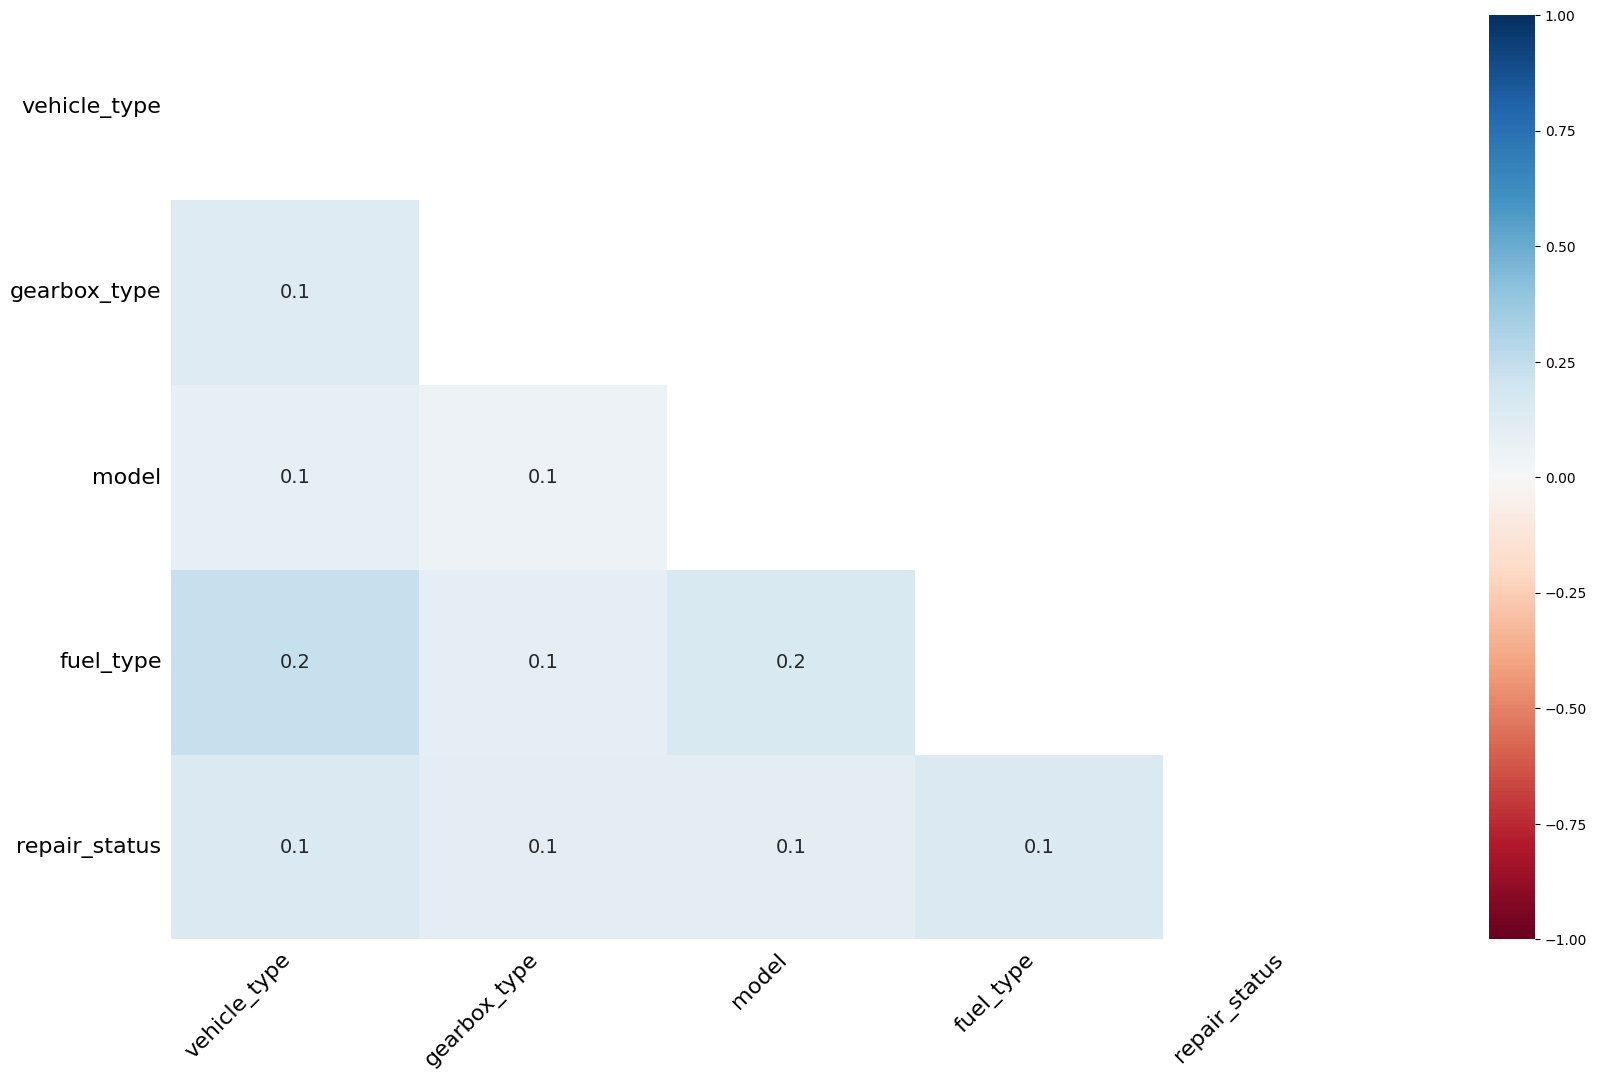

In [177]:
msno.heatmap(auto_data)

можно заметить, что пропуски содержаться только в категоральных столбцах, что делает их замену довольно трудной задачей, так признак repair_status содержит целых 13.5% пропущенных значений. Из-за того, что столбец категориальный, будет трудно правильно импутировать значение, а значит, следует выбирать между удалением столбца, удалением строк с пропусками и заменой пропусков на какое-то одно значение.

В ходе дальнейшего анализа выясним, что этот признак сильно влияет на резльтат и его удаление приведёт к потере большого колличества значений, что может негативно сказаться на точности модели. Была выбрана стратегия замены на новую категорию unknown. Остальные же признаки содержат небольшое колличество пропуск, следовательно их удаление не приведёт к критической потери точности модели

In [178]:
auto_data['repair_status'].fillna('unknown', inplace=True)
auto_data.dropna(inplace=True)


C:\Users\Влад\AppData\Local\Temp\ipykernel_18760\2273102119.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  auto_data['repair_status'].fillna('unknown', inplace=True)


#### Проверка на наличие дубликатов

Посмотрим сколько явных дубликатов содержат данные

In [179]:
auto_data.duplicated().sum()

np.int64(14711)

Довольно большок количество повторяющихся значений. Следует узнать у сервиса, не произошло ли каких-либо ошибок в процессе сбора и выгрузки данных

In [180]:
auto_data.drop_duplicates(inplace=True)

Теперь проверим данные на наличие неявных дубликатов

In [181]:
for col in auto_data.select_dtypes(include=['object']):
    print(f' {col}: {auto_data[col].unique()}\n')

 vehicle_type: ['suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe' 'other']

 gearbox_type: ['auto' 'manual']

 model: ['grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other' 'civic'
 'transporter' 'punto' 'e_klasse' 'one' 'fortwo' 'clio' '1er' 'b_klasse'
 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a1' 'focus' 'a4' 'tt' 'astra' 'a6' 'jazz'
 'polo' 'slk' '7er' 'combo' 'corsa' '80' '147' 'z_reihe' 'sorento' 'ibiza'
 'mustang' 'eos' 'touran' 'getz' 'insignia' 'ka' 'megane' 'a3' 'lupo'
 'r19' 'mondeo' 'colt' 'vectra' 'berlingo' 'tiguan' '6_reihe' 'c4' 'panda'
 'up' 'i_reihe' 'ceed' 'kangoo' '5_reihe' 'yeti' 'octavia' 'zafira' 'mii'
 'rx_reihe' '6er' 'fox' 'matiz' 'beetle' 'rio' 'touareg' 'logan' 'caddy'
 'omega' 'cuore' 's_max' 'modus' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'sharan' 'avensis' 'roomster' 'sl' 'santa' 'leon' 'cooper' 'a5'


gasoline' и 'petrol', 'rangerover' и 'range_rover' - это одно и то же, так что нужно объединить

In [182]:
auto_data['fuel_type'] = auto_data['fuel_type'].apply(lambda x: 'petrol' if x == 'gasoline' else x)
auto_data['brand'] = auto_data['brand'].apply(lambda x: 'rangerover' if x == 'range_rover' else x) 

#### Корреляционный анализ  

Посмотрим, как взаимосвязаны признаки в датасете

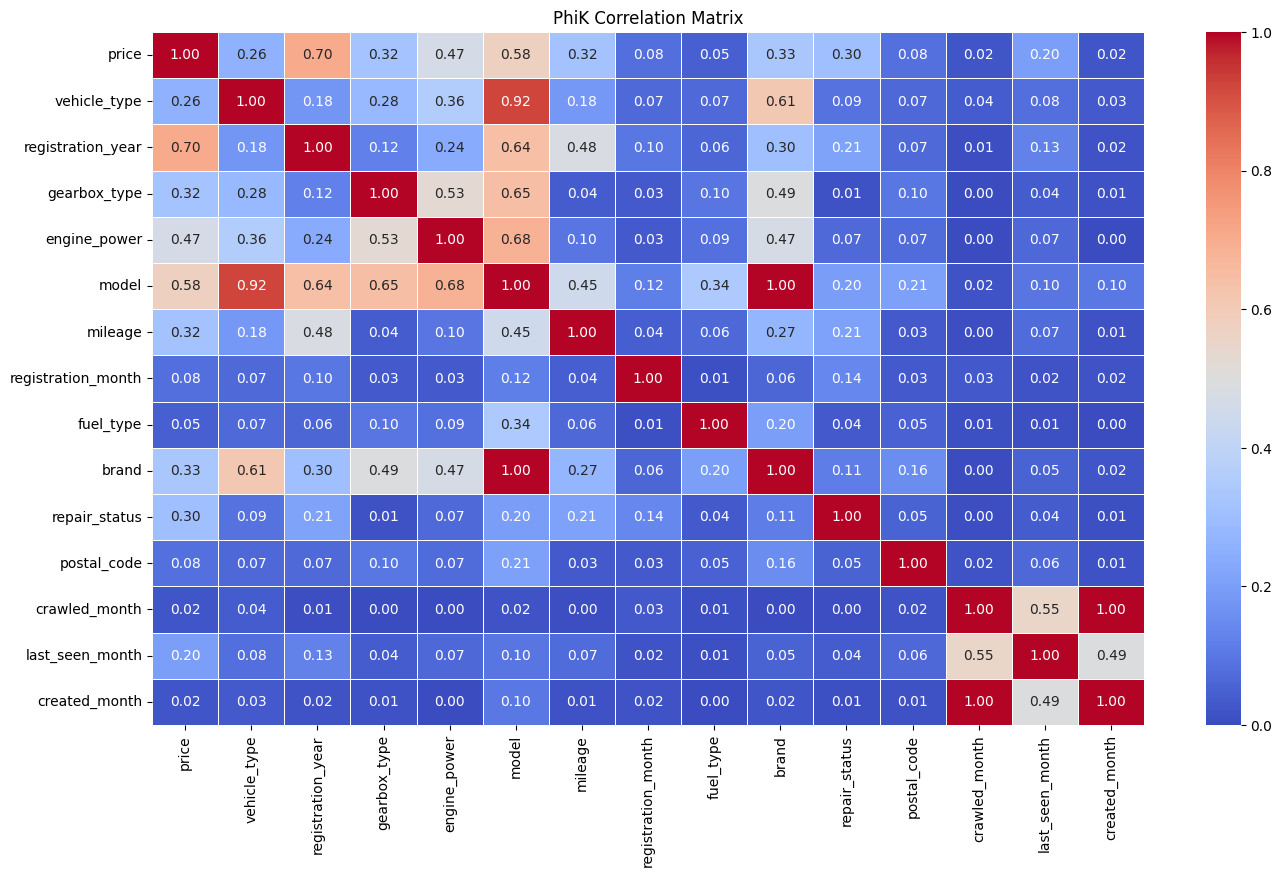

In [183]:
corr_matrix = auto_data.phik_matrix(interval_cols=['price', 'registration_year', 'engine_power', 'mileage',
                                                       'registration_month', 'postal_code'])

plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('PhiK Correlation Matrix')
plt.show();

##### Что мы можем сказать по графику  

признаки model и brand, vechicle_type и model, crawled_month и created_month мультиколлинеарны и следует оставить только те, которые имеют бОльшую связь с таргетом  

признаки model, registration_year, engine power имеют среднюю корреляцию с результаивной переменной  

Признаки vehicle_type, gearbox_type, mileage, brand, repair_status, last_seen_month слабо коррелируют с таргетом

Остальные признаки слишком слабо(или вообще никак) не влияют на price  

В ходе корреляционного анализы выяснили какие из признаков следует удалить из модели

brand, vehicle_type (мультиколлинеарны с более важным признаком model)

registration_month, postal_code, crawled_month, created_month (не коррелируют с таргетом)

In [184]:
auto_data_ready = auto_data.drop(
                ['brand', 'vehicle_type', 'registration_month',
                 'postal_code', 'crawled_month', 'created_month', 'fuel_type'],
                axis=1
            )

#### В результате загрузки данных и первичного анализа:

был загружен датасет auto_data_raw  
временные столбцы были преобразованы в числовые по месяцам  
были удалены аномальные значения в числовых столбцах  
обработаны пропущенные значения(так, в признаке repair_status появилось значение 'unknown' вместо пропуска, в то время как остальные редко   встречающиеся пропуски были удалены из датасета)  
произведён корреляционный анализ, в результате которого были удалены неинформативные колонки  
все изменения были сохранены в **auto_data_ready**  

### Обучение моделей

In [185]:
RANDOM_STATE = 42
X = auto_data_ready.drop('price', axis=1)
y = auto_data_ready['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.1)

In [186]:
ord_cols = ['model', 'registration_year']
ohe_cols = ['gearbox_type', 'repair_status', 'last_seen_month']
num_cols = ['engine_power', 'mileage']

Построим пайплайн для подготовки категориальных данных

In [187]:
ohe_pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

ord_pipe = Pipeline([
    ('impute_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ('impute_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ])

### Построение и обучение моделей

Заказчику очень важно качества пресказаний модели + целевая переменная в реальных единицах, а значит, можно использовать RMSE как метрику для оценки качества предсказаний моделей

Для начала, посмотрим, как линейная регрессия справится с этой задачей(всё-таки у нас есть признаки, которые сильно взаимосвязаны с таргетом)

In [188]:
data_prerocessor1 = ColumnTransformer([
    ('ohe', ohe_pipe, ord_cols+ohe_cols),
    ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough')

lr_pipe = Pipeline([
    ('preprosessor', data_prerocessor1),
    ('model', LinearRegression())
])

In [189]:
lr_rmse = -cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

start_l = time.time()
lr_pipe.fit(X_train, y_train)
end_l = time.time()

start_p = time.time()
lr_pipe.predict(X_test)
end_p = time.time()

lr_stats = {
    'Время обучения': round(end_l - start_l, 3),
    'Время предсказания': round(end_p - end_l, 3),
    'RMSE': round(lr_rmse, 3 )
}

for key, value in lr_stats.items():
    print(f'{key}: {value} ')

e:\проекты\Проекты по DS\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
e:\проекты\Проекты по DS\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Время обучения: 6.922 
Время предсказания: 0.122 
RMSE: 2060.629 


e:\проекты\Проекты по DS\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Созданим функцию, для добавления результатов обучения в словарь и удобного вывода

In [190]:
def find_preprosessing_score(model):
    results_df = pd.DataFrame(model.cv_results_)
    best_scores_df = results_df[results_df['rank_test_score'] == 1]

    model_stats = {
        'Время обучения': round(best_scores_df['mean_fit_time'].iloc[0], 3),
        'Время предсказания': round(best_scores_df['mean_score_time'].iloc[0], 3),
        'RMSE': round(-model.best_score_,3)
    }

    for key, value in model_stats.items():
        print(f'{key}: {value}')
    return model_stats

Модель выдала приемлемое время обучения и предсказания и неплохую точность

Попробуем применить регуляризацию для улучшения точности модели

Используем ElasticNet для комбинации преимуществ L1 и L2 регуляризации, для этого соберём пайплайн

In [191]:
elastic_pipe = Pipeline([
    ('preprosessor', data_prerocessor1),
    ('model', ElasticNet(alpha=0.5))
])

In [192]:
elastic_params = {
    'model__alpha': np.logspace(-4, 2, 100),        
    'model__l1_ratio': np.linspace(0, 1, 100),       
    'model__tol': [1e-2, 1e-3, 1e-4],
    'model__selection': ['cyclic', 'random']
}


elastic_search = RandomizedSearchCV(
    elastic_pipe,
    elastic_params,
    n_iter=30,           
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

elastic_search.fit(X_train, y_train)
elastic_stats = find_preprosessing_score(elastic_search)

KeyboardInterrupt: 

Регуляризатор показал себя немного лучше, уменьшив значение целевой метрики

Следующей моделью будет Random Forest

In [ ]:
data_prerocessor2 = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', StandardScaler(), num_cols)
])

rf_pipe = Pipeline([
    ('preposessor', data_prerocessor2),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE))
])

In [ ]:
rf_params_grid = {
    'model__n_estimators': np.arange(100, 1001, 100),    
    'model__max_depth': np.arange(3, 31, 3),                
    'model__min_samples_split': np.arange(2, 21, 2),       
    'model__min_samples_leaf': np.arange(1, 11, 2),        
    'model__max_features': np.linspace(0.3, 1.0, 8),        
    'model__bootstrap': [True, False]                       
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    rf_params_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1
)

rf_search.fit(X_train, y_train)
rf_stats = find_preprosessing_score(rf_search)

Время обучения: 3.053
Время предсказания: 0.123
RMSE: 2101.41


Значения метрики уменьшилось не значительно по сравнения с ElasticNet, при этом время обучения значительно отличается

Теперь посомтрим на модель LightGBM

In [ ]:
data_prerocessor3 = ColumnTransformer([
    ('cat_ord', ord_pipe, ord_cols),
    ('cat_ohe', ohe_pipe, ohe_cols),
    ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough')

lgbm_pipe = Pipeline([
    ('preprocessor', data_prerocessor3),
    ('lgbm', LGBMRegressor())
])

In [ ]:
lgbm_params = {
    'lgbm__n_estimators': [300, 500],
    'lgbm__learning_rate': [0.1, 0.3, 0.5]
}

In [ ]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()



In [ ]:
lgbm_search = GridSearchCV(
    lgbm_pipe,
    lgbm_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

lgbm_search.fit(X_train_lgbm, y_train)
lgbm_stat = find_preprosessing_score(lgbm_search)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 648, number of used features: 8
[LightGBM] [Info] Start training from score 5262.342593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
models = ['LinearRegression', 'ElasticNet','RandomForestRegressor', 'LGBMRegressor']
models_info = [lr_stats, elastic_stats, rf_stats, lgbm_stat]

pd.DataFrame(models_info, index=models)

,Время обучения,Время предсказания,RMSE
LinearRegression,0.047,0.007,2483.335
ElasticNet,0.051,0.011,2187.533
RandomForestRegressor,3.053,0.123,2101.410
LGBMRegressor,6.283,0.025,2255.492
